In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

c:\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### einops Module

- numpy 대신 사용할 수 있는 텐서 차원 관리 모듈
- 매우 직관적

In [2]:
from einops import rearrange, reduce, repeat

input_tensor = torch.Tensor([[[2,3]]])

print(input_tensor, input_tensor.shape)
output_tensor = rearrange(input_tensor, 't b c -> b c t')
# 각 차원이 가지는 의미를 space seprated하게 입력, -> 원하는 방식으로 수정하는 요청

print(output_tensor, output_tensor.shape)

input_tensor = torch.Tensor([[[[1,2],[2,3]]]])

print(input_tensor, input_tensor.shape)
output_tensor = reduce(input_tensor, 'b c (h h2) (w w2) -> b h w c', 'mean', h2=2, w2=2)
# str로 작성하는 pattern이 자연어에 가깝, 기존 사용법보다 사용하기 쉽고, 해석하기도 쉬움
# 소괄호()로 묶으면 해당 차원 크기가 곱해짐
print(output_tensor, output_tensor.shape)

tensor([[[2., 3.]]]) torch.Size([1, 1, 2])
tensor([[[2.],
         [3.]]]) torch.Size([1, 2, 1])
tensor([[[[1., 2.],
          [2., 3.]]]]) torch.Size([1, 1, 2, 2])
tensor([[[[2.]]]]) torch.Size([1, 1, 1, 1])


#### Layer

- Deep Learning Framework와 일반 layer module과 같이 쓸 수 있는 Rearrange와 Reduce, 2가지 layer가 제공됨
- framework에 따라 instance를 만들고 forward를 통해 tensor나 variable을 조작할 수 있음


In [3]:
# from einops.layers.torch import Rearrange, Reduce

# layer = Rearrange(pattern, **axes_lengths)
# layer = Reduce(pattern, reduction, **axes_lengths)

from torch.nn import Sequential, Conv2d, MaxPool2d, Linear, ReLU
from einops.layers.torch import Rearrange

model = Sequential(
    Conv2d(3, 6, kernel_size=5),
    MaxPool2d(kernel_size=2),
    Conv2d(6, 16, kernel_size=5),
    MaxPool2d(kernel_size=2),
    # flattening
    Rearrange('b c h w -> b (c h w)'),  
    Linear(16*5*5, 120), 
    ReLU(),
    Linear(120, 10), 
)


In [4]:
# batch size = 8, 224 * 224 * 3 이미지 생성
x = torch.randn(8, 3, 224, 224)
x.shape

torch.Size([8, 3, 224, 224])

In [5]:
# ViT의 경우 image를 n * (P X P X C) patch로 나눠줘야함
# n은 patch 개수 -> (H * W / (P * P))
# 아래 작업은 바로 flatten까지 작업 가능

patch_size = 16 # 16 pixels
print('x : ', x.shape)
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
print('patches :', patches.shape)

print((224*224) // (patch_size*patch_size), (patch_size * patch_size * 3))

x :  torch.Size([8, 3, 224, 224])
patches : torch.Size([8, 196, 768])
196 768


In [6]:
# 실제 ViT의 경우 einops를 사용한 Linear Embedding이 아닌
# 2D Conv를 통해 kernel size, stride size를 patch_size로 갖는 feature map을 flatten 시켜줌
# 이는 linear를 사용하는 것보다 performance gain이 잇음

patch_size = 16
in_channels = 3
emb_size = 768

projection = nn.Sequential(
    # conv2d를 통해 feature map을 flatten하는 것이 성능면에서 이득
    nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
    Rearrange('b e (h) (w) -> b (h w) e'),
)

projection(x).shape

torch.Size([8, 196, 768])

In [7]:
# 학습을 위해 CLS Token과 Positional Encoding을 추가

emb_size = 768
img_size = 224
patch_size = 16

projected_x = projection(x)
print('Projected X shape :', projected_x.shape)

# cls token과 pos encoding parameter 정의
cls_token = nn.Parameter(torch.randn(1,1, emb_size))
positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size)) # (H * W) // (P * P) + cls
print('CLS Shape :', cls_token.shape, 'Pos Shape :', positions.shape)

# cls_token을 반복하여, 배치사이즈의 크기와 맞춰줌
batch_size = 8
cls_tokens = repeat(cls_token, '() n e -> b n e', b=batch_size)
print('Repeated CLS shape :', cls_tokens.shape)

# cls_token과 projected_x를 concatenate
cat_x = torch.cat([cls_tokens, projected_x], dim=1)

# position encoding을 더해줌
cat_x += positions
print('Output :', cat_x.shape)

Projected X shape : torch.Size([8, 196, 768])
CLS Shape : torch.Size([1, 1, 768]) Pos Shape : torch.Size([197, 768])
Repeated CLS shape : torch.Size([8, 1, 768])
Output : torch.Size([8, 197, 768])


In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()

        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions

        return x


In [9]:
# Mulit-head Attention
## Query, Value, Key는 Linear를 통해 임베딩한 후, 여러 Head로 나뉘어 attention 수행

emb_size = 768
num_heads = 8 # Transformer에서 많이 사용하는 head수

keys = nn.Linear(emb_size, emb_size)
queries = nn.Linear(emb_size, emb_size)
values = nn.Linear(emb_size, emb_size)

# 각 Linear Layer는 모델 훈련과정에서 학습됨
print(keys, queries, values)

Linear(in_features=768, out_features=768, bias=True) Linear(in_features=768, out_features=768, bias=True) Linear(in_features=768, out_features=768, bias=True)


In [10]:
# Mulit-head Attention

queries = rearrange(queries(cat_x), "b n (h d) -> b h n d", h=num_heads)
keys = rearrange(keys(cat_x), "b n (h d) -> b h n d", h=num_heads)
values = rearrange(values(cat_x), "b n (h d) -> b h n d", h=num_heads) # 즉 d는 768 // 8

print("shape :", queries.shape, keys.shape, values.shape)

shape : torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96])


$$ \color{green}{C_{j}}\color{black}{=\sum\limits_{i}\sum\limits_{k}} \color{red}{A_{ik}} \color{blue}{B_{kj}} \color{black}{=} \color{red}{A_{ik}} \color{blue}{B_{kj}} $$

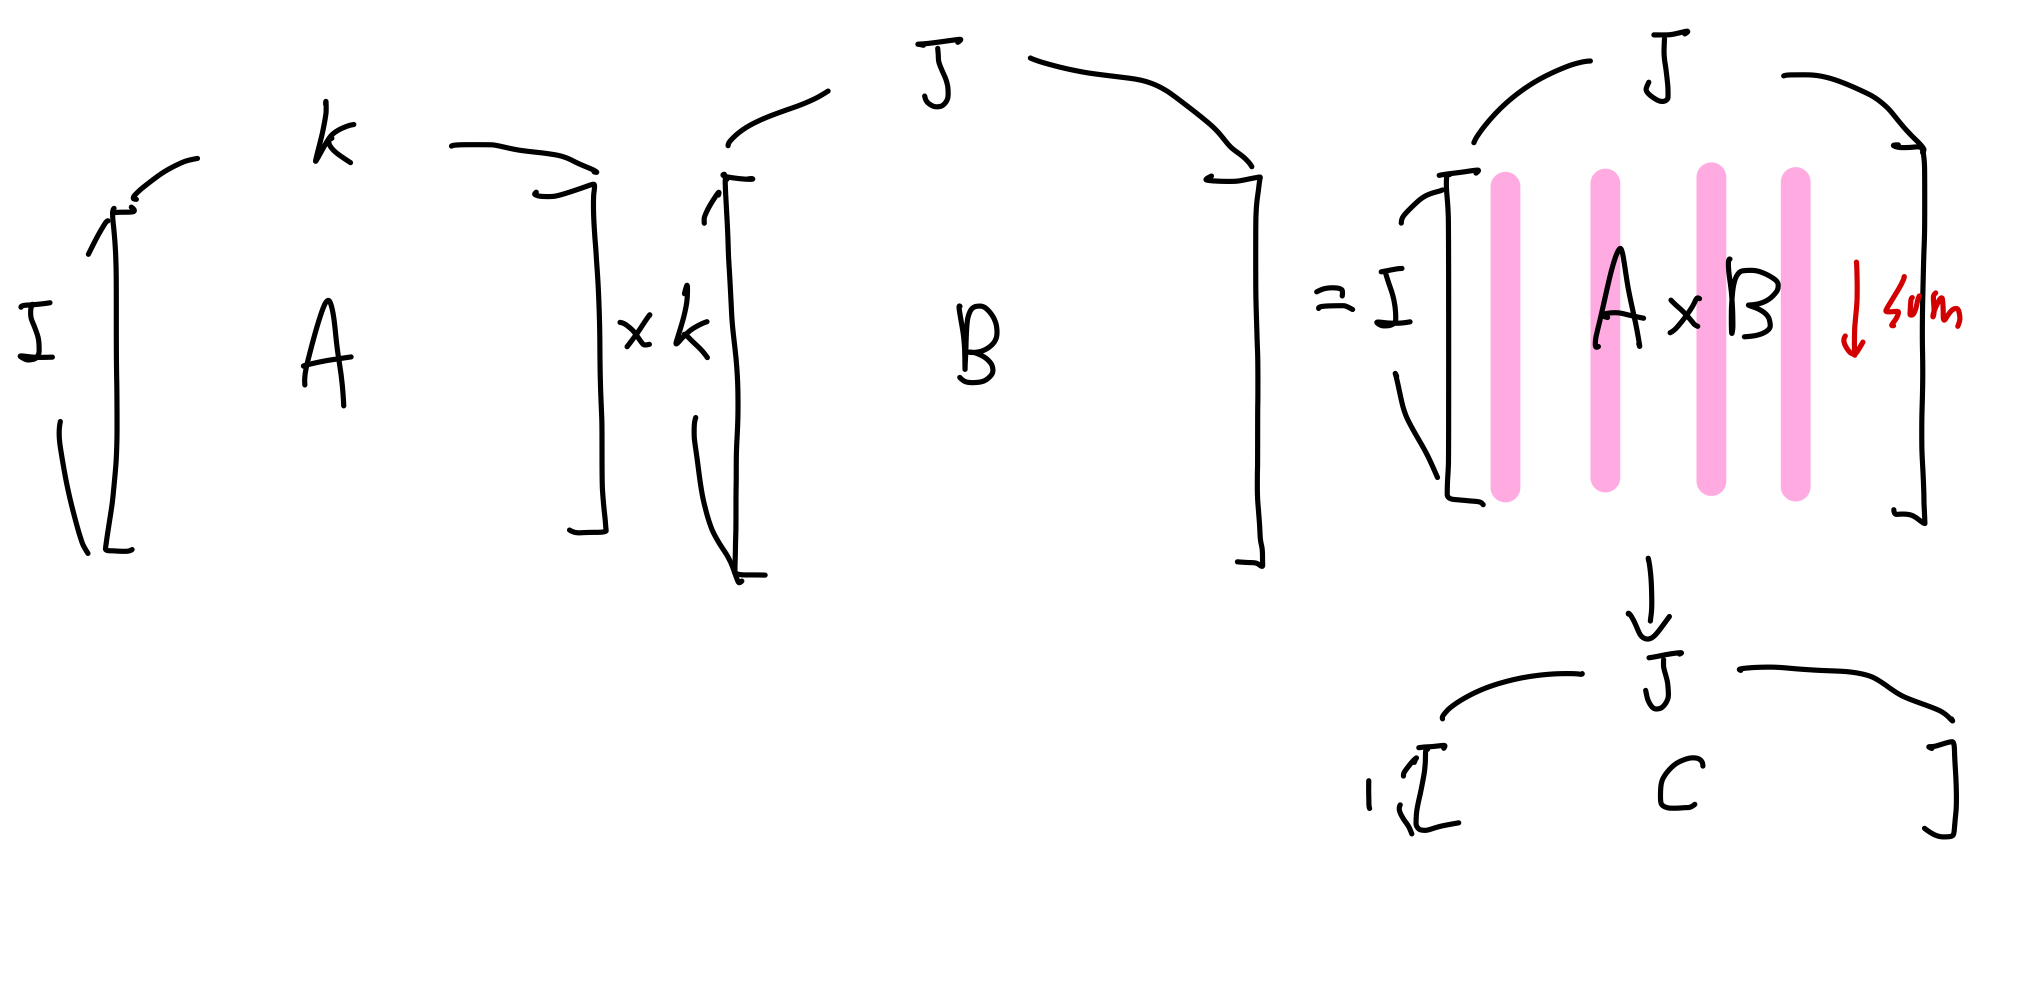

In [11]:
# Self Attention

# scaled dot-product attention 수행
query_key = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
print('query_key :', query_key.shape)

# Get attention score
scaling = emb_size ** (0.5) # root(d_k)
attention = F.softmax(query_key, dim=-1) / scaling
print('attention :', attention.shape)

# Attention * values
out = torch.einsum('bhal, bhlv -> bhav', attention, values)
print('out :', out.shape)

# Rearrange to emb_size
out = rearrange(out, "b h n d -> b n (h d)")
print('out2 :', out.shape)


query_key : torch.Size([8, 8, 197, 197])
attention : torch.Size([8, 8, 197, 197])
out : torch.Size([8, 8, 197, 96])
out2 : torch.Size([8, 197, 768])


In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        # query, key, values linear layer로 나눔
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [13]:
# Residual Block
## Resnet에서 사용된 이전 데이터 손실을 가져갈 수 있도록 사용한 기법

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        
        return x

In [14]:
# Feed Forward MLP
## expansion -> embedding size를 늘렸다가 줄임
## Sequential을 상속받으면 forward 함수를 정의하지 않아도 됨

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion = 4, drop_p=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [15]:
# Transformer Encoder Block

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=768,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.,
                 **kwarags):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwarags),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p
                ),
                nn.Dropout(drop_p)
            ))
        )

In [16]:
x = torch.randn(8, 3, 224, 224)
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([8, 197, 768])

In [17]:
# Encoder Block 쌓기
# 이때 depth는 몇 개 층으로 쌓을 것인지를 의미
# list앞에 *은 block을 각각 보내줘야함

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [18]:
# classification Head -> 1000개 분류

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=768, n_classes=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'), # 1차원 vector로 embedding
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

In [19]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 4,
                emb_size: int = 48,
                img_size: int = 32,
                depth: int = 12,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        
summary(ViT(), (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 48, 8, 8]           2,352
         Rearrange-2               [-1, 64, 48]               0
    PatchEmbedding-3               [-1, 65, 48]               0
         LayerNorm-4               [-1, 65, 48]              96
            Linear-5              [-1, 65, 144]           7,056
           Dropout-6            [-1, 8, 65, 65]               0
            Linear-7               [-1, 65, 48]           2,352
MultiHeadAttention-8               [-1, 65, 48]               0
           Dropout-9               [-1, 65, 48]               0
      ResidualAdd-10               [-1, 65, 48]               0
        LayerNorm-11               [-1, 65, 48]              96
           Linear-12              [-1, 65, 192]           9,408
             GELU-13              [-1, 65, 192]               0
          Dropout-14              [-1, 

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


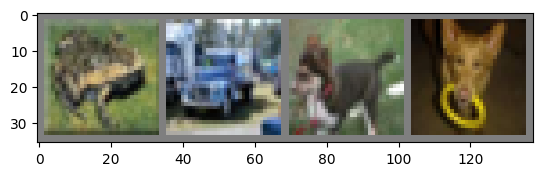

frog  truck dog   dog  


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [23]:
import torch.optim as optim

net = ViT()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
import sys

for epoch in range(10):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    tmp = sys.maxsize
    patience = 0

    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            if tmp > (running_loss / 2000):
                tmp = running_loss / 2000
                patience = 0
            else:
                patience += 1
                if patience == 5:
                    print('더 이상 학습되지 않습니다.')
                    break
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.137
[1,  4000] loss: 2.032
[1,  6000] loss: 2.004
[1,  8000] loss: 1.944
[1, 10000] loss: 1.891
[1, 12000] loss: 1.858
[2,  2000] loss: 1.803
[2,  4000] loss: 1.783
[2,  6000] loss: 1.747


KeyboardInterrupt: 

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

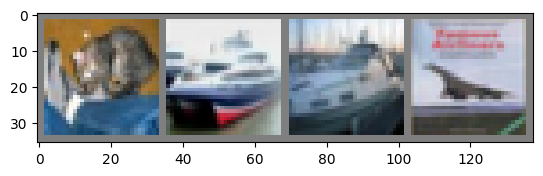

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = ViT()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  plane


In [ ]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 40 %


In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.8 %
Accuracy for class: car   is 68.5 %
Accuracy for class: bird  is 54.6 %
Accuracy for class: cat   is 37.3 %
Accuracy for class: deer  is 4.5 %
Accuracy for class: dog   is 25.0 %
Accuracy for class: frog  is 43.7 %
Accuracy for class: horse is 36.6 %
Accuracy for class: ship  is 46.9 %
Accuracy for class: truck is 24.4 %
